# Image Classification using Logistic Regression in PyTorch

Use existing knowledge of PyTorch and linear regression to solve a very different kind of problem: image classification. We'll use the famous [*MNIST Handwritten Digits Database*](http://yann.lecun.com/exdb/mnist/) as our training dataset. It consists of 28px by 28px grayscale images of handwritten digits (0 to 9), along with labels for each image indicating which digit it represents. Here are some sample images from the dataset:

![Dataset to be used](./Images/6.jpg "Dataset")



## Exploring the Data
We begin by importing <code>torch</code> and <code>torchvision</code>. <code>torchvision</code> contains some utilities for working with image data. It also contains helper classes to automatically download and import popular datasets like MNIST.

In [18]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST

In [19]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

When this statement is executed for the first time, it downloads the data to the <code>data/</code> directory next to the notebook and creates a PyTorch <code>Dataset</code>. On subsequent executions, the download is skipped as the data is already downloaded. Let's check the size of the dataset.

In [20]:
len(dataset)

60000

The dataset has 60,000 images which can be used to train the model. There is also an additonal test set of 10,000 images which can be created by passing <code>train=False</code> to the <code>MNIST</code> class.

In [21]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

Let's look at a sample element from the training dataset.

In [22]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x20AAFAFF1D0>, 5)

It's a pair, consisting of a 28x28 image and a label. The image is an object of the class <code>PIL.Image.Image</code>, which is a part of the Python imaging library [Pillow](https://pillow.readthedocs.io/en/stable/). We can view the image within Jupyter using <code><u>matplotlib</u></code>, the de-facto plotting and graphing library for data science in Python.

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

Along with importing <code>matplotlib</code>, a special statement <code>%matplotlib inline</code> is added to indicate to Jupyter that we want to plot the graphs within the notebook. Without this line, Jupyter will show the image in a popup. Statements starting with <code>%</code> are called IPython magic commands, and are used to configure the behavior of Jupyter itself. You can find a full list of magic commands here: https://ipython.readthedocs.io/en/stable/interactive/magics.html .

Let's look at a couple of images from the dataset.

label: 5


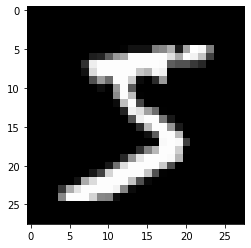

In [24]:
im, lab = dataset[0]
plt.imshow(im, cmap = 'gray')
print('label:', lab)

label: 3


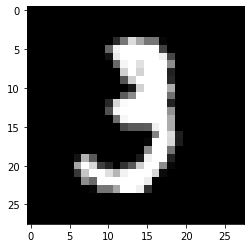

In [25]:
im, lab = dataset[10]
plt.imshow(im, cmap = 'gray')
print('label:', lab)

It's evident that these images are quite small in size, and recognizing the digits can sometimes be hard even for the human eye. While it's useful to look at these images, there's just one problem here: PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [26]:
import torchvision.transforms as transforms

PyTorch datasets allow us to specify one or more transformation functions which are applied to the images as they are loaded. <code>torchvision.transforms</code> contains many such predefined functions, and we'll use the <code>ToTensor</code> transform to convert images into PyTorch tensors.

In [27]:
dataset = MNIST(root = 'data/',
                train = True,
                transform = transforms.ToTensor())

In [28]:
im_tensor, label = dataset[0]
print(im_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The image is now converted to a 1x28x28 tensor. The first dimension is used to keep track of the color channels. Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are 3 channels: red, green and blue (RGB). Let's look at some sample values inside the tensor:

In [29]:
print(im_tensor[:,10:15,10:15])
print(torch.max(im_tensor), torch.min(im_tensor))

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)


The values range from 0 to 1, with 0 representing black, 1 white and the values in between different shades of grey. We can also plot the tensor as an image using <code>plt.imshow</code>.

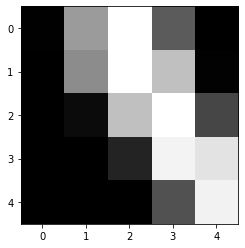

In [30]:
plt.imshow(im_tensor[0,10:15,10:15], cmap = 'gray')

Note that we need to pass just the 28x28 matrix to <code>plt.imshow, without a channel dimension. We also pass a color map (<code>cmap=gray) to indicate that we want to see a grayscale image.

Training and Validation Datasets
While building real world machine learning models, it is quite common to split the dataset into 3 parts:

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

In the MNIST dataset, there are 60,000 training images, and 10,000 test images. The test set is standardized so that different researchers can report the results of their models against the same set of images. Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets.

Let's define a function that randomly picks a given fraction of the images for the validation set.



In [31]:
import numpy as np

def split_indices(n, val_pct):
    #Determine size of validation set
    n_val = int(val_pct*n)
    # Create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indics for validation set
    return idxs[n_val:], idxs[:n_val]

<code>split_indices</code> randomly shuffles the array indices <code>0,1,..n-1</code>, and separates out a desired portion from it for the validation set. It's important to shuffle the indices before creating a validation set, because the training images are often ordered by the target labels i.e. images of 0s, followed by images of 1s, followed by images of 2s and so on. If we were to pick a 20% validation set simply by selecting the last 20% of the images, the validation set would only consist of images of 8s and 9s, whereas the training set would contain no images of 8s and 9s. This would make it impossible to train a good model using the training set, which also performs well on the validation set (and on real world data).

In [32]:
train_indices, val_indices = split_indices(len(dataset), val_pct = 0.2)

In [33]:
print(len(train_indices), len(val_indices))
print('Sample val indices: ', val_indices[:20])

48000 12000
Sample val indices:  [22419 46767 26653 34508 36625  3618 24609 25423 29390 19099 40331  8796
 54687 55125 48871  2195 45141 26478 38629 24671]


We have randomly shuffled the indices, and selected a small portion ( 20% ) to serve as the validation set. We can now create Pytorch data loaders for each of these using a <code>SubsetRandomSampler</code>, which samples elements randomly from a given list of indices, while greating batches of data.



In [34]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [35]:
batch_size = 100

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, 
                          batch_size, 
                          sampler = train_sampler)

# Validation sampler and dataa loader
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, 
                        batch_size, 
                        sampler = val_sampler)

###### Alternative Approach
Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the <code>random_spilt</code> method from PyTorch.



In [36]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

It's important to choose a random sample for creating a validation set, because training data is often ordered by the target labels i.e. images of 0s, followed by images of 1s, followed by images of 2s and so on. If we were to pick a 20% validation set simply by selecting the last 20% of the images, the validation set would only consist of images of 8s and 9s, whereas the training set would contain no images of 8s and 9s. This would make it impossible to train a good model using the training set, which also performs well on the validation set (and on real world data).

We can now created data loaders to help us load the data in batches. We'll use a batch size of 128.



In [37]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)


We set <code>shuffle=True</code> for the training dataloader, so that the batches generated in each epoch are different, and this randomization helps generalize & speed up the training process. On the other hand, since the validation dataloader is used only for evaluating the model, there is no need to shuffle the images.



### Model
Now that we have prepared our data loaders, we can define our model.

* A logistic regression model is almost identical to a linear regression model i.e. there are weights and bias matrices, and the output is obtained using simple matrix operations (<code>pred = x @ w.t() + b</code>).

* Just as we did with linear regression, we can use <code>nn.Linear</code> to create the model instead of defining and initializing the matrices manually.

* Since <code>nn.Linear</code> expects the each training example to be a vector, each <code>1x28x28</code> image tensor needs to be flattened out into a vector of size 784 (<code>28*28</code>), before being passed into the model.

* The output for each image is vector of size 10, with each element of the vector signifying the probability a particular target label (i.e. 0 to 9). The predicted label for an image is simply the one with the highest probability.



In [38]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

Of course, this model is a lot larger than our previous model, in terms of the number of parameters. Let's take a look at the weights and biases.



In [39]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-0.0244,  0.0093,  0.0347,  ..., -0.0245, -0.0248,  0.0309],
        [-0.0354,  0.0073,  0.0170,  ...,  0.0308, -0.0238,  0.0143],
        [ 0.0085,  0.0002,  0.0258,  ..., -0.0199, -0.0025, -0.0210],
        ...,
        [-0.0257,  0.0210,  0.0220,  ...,  0.0201,  0.0227, -0.0293],
        [-0.0102, -0.0017, -0.0275,  ...,  0.0048,  0.0128,  0.0130],
        [ 0.0165,  0.0192, -0.0120,  ...,  0.0248, -0.0204, -0.0305]],
       requires_grad=True)

In [40]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([ 0.0338,  0.0026,  0.0275, -0.0101, -0.0346, -0.0193,  0.0330,  0.0174,
        -0.0135,  0.0284], requires_grad=True)

Although there are a total of 7850 parameters here, conceptually nothing has changed so far. Let's try and generate some outputs using our model. We'll take the first batch of 100 images from our dataset, and pass them into our model.



In [41]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    break

tensor([5, 1, 1, 2, 7, 7, 7, 2, 2, 0, 2, 6, 4, 1, 3, 7, 1, 2, 5, 6, 2, 5, 2, 7,
        1, 6, 1, 9, 4, 7, 4, 5, 9, 9, 6, 5, 2, 5, 7, 7, 3, 5, 1, 1, 4, 1, 8, 1,
        1, 3, 1, 3, 3, 0, 3, 2, 3, 3, 3, 7, 4, 3, 8, 4, 4, 4, 4, 6, 3, 5, 2, 4,
        7, 4, 5, 3, 5, 2, 1, 3, 6, 1, 5, 9, 5, 3, 9, 1, 0, 1, 6, 2, 4, 0, 9, 2,
        2, 4, 1, 3, 7, 2, 6, 1, 5, 8, 3, 3, 6, 9, 3, 2, 1, 0, 6, 2, 8, 7, 9, 6,
        1, 0, 8, 9, 9, 6, 6, 4])
torch.Size([128, 1, 28, 28])


RuntimeError: size mismatch, m1: [3584 x 28], m2: [784 x 10] at C:\w\1\s\tmp_conda_3.6_095855\conda\conda-bld\pytorch_1579082406639\work\aten\src\TH/generic/THTensorMath.cpp:136

This leads to an error, because our input data does not have the right shape. Our images are of the shape 1x28x28, but we need them to be vectors of size 784 i.e. we need to flatten them out. We'll use the <code>.reshape</code> method of a tensor, which will allow us to efficiently 'view' each image as a flat vector, without really chaging the underlying data.

To include this additional functionality within our model, we need to define a custom model, by extending the <code>nn.Module</code> class from PyTorch.



In [42]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()

Inside the <code>\_\_init__</code> constructor method, we instantiate the weights and biases using <code>nn.Linear</code>. And inside the forward method, which is invoked when we pass a batch of inputs to the model, we flatten out the input tensor, and then pass it into <code>self.linear</code>.

<code>xb.reshape(-1, 28\*28)</code> indicates to PyTorch that we want a view of the xb tensor with two dimensions, where the length along the 2nd dimension is <code>28*28</code> (i.e. 784). One argument to <code>.reshape</code> can be set to <code>-1</code> (in this case the first dimension), to let PyTorch figure it out automatically based on the shape of the original tensor.

Note that the model no longer has <code>.weight</code> and <code>.bias</code> attributes (as they are now inside the <code>.linear</code> attribute), but it does have a <code>.parameters</code> method which returns a list containing the weights and bias, and can be used by a PyTorch optimizer.



In [43]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[-0.0092, -0.0011, -0.0122,  ..., -0.0139,  0.0283, -0.0033],
         [-0.0322,  0.0150,  0.0001,  ...,  0.0066, -0.0340,  0.0167],
         [ 0.0269,  0.0325,  0.0151,  ..., -0.0079,  0.0160,  0.0113],
         ...,
         [ 0.0081,  0.0089,  0.0233,  ...,  0.0334,  0.0289,  0.0094],
         [-0.0304, -0.0048, -0.0160,  ...,  0.0086, -0.0146,  0.0226],
         [-0.0008,  0.0326, -0.0264,  ...,  0.0133,  0.0147, -0.0279]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0078, -0.0283,  0.0218, -0.0357,  0.0306,  0.0305, -0.0144,  0.0193,
         -0.0116, -0.0285], requires_grad=True)]

Our new custom model can be used in the exact same way as before. Let's see if it works.

In [44]:
for images, labels in train_loader:
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0536, -0.3660,  0.0531, -0.3092, -0.0667,  0.1105, -0.0331,  0.0827,
          0.1090, -0.4181],
        [-0.3313, -0.4016,  0.3468, -0.0280,  0.0489,  0.3299,  0.5586,  0.0264,
          0.2018,  0.0809]])


For each of the 100 input images, we get 10 outputs, one for each class. As discussed earlier, we'd like these outputs to represent probabilities, but for that the elements of each output row must lie between 0 to 1 and add up to 1, which is clearly not the case here.

To convert the output rows into probabilities, we use the softmax function, which has the following formula:

![Formula](./Images/7.png "Formula")

First we replace each element <code>y_{i}</code> in an output row by <code>e^{y_{i}}</code>, which makes all the elements positive, and then we divide each element by the sum of all elements to ensure that they add up to 1.

While it's easy to implement the softmax function (you should try it!), we'll use the implementation that's provided within PyTorch, because it works well with multidimensional tensors (a list of output rows in our case).


The softmax function is included in the torch.nn.functional package, and requires us to specify a dimension along which the softmax must be applied.

In [ ]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())


Finally, we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. This is done using torch.max, which returns the largest element and the index of the largest element along a particular dimension of a tensor.

In [ ]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

The numbers printed above are the predicted labels for the first batch of training images. Let's compare them with the actual labels.

In [ ]:
labels

Clearly, the predicted and the actual labels are completely different. Obviously, that's because we have started with randomly initialized weights and biases. We need to train the model i.e. adjust the weights using gradient descent to make better predictions.

### Evaluation Metric and Loss Function

Just as with linear regression, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly i.e. the accuracy of the predictions.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

The == performs an element-wise comparison of two tensors with the same shape, and returns a tensor of the same shape, containing 0s for unequal elements, and 1s for equal elements. Passing the result to torch.sum returns the number of labels that were predicted correctly. Finally, we divide by the total number of images to get the accuracy.

Note that we don't need to apply softmax to the outputs, since it doesn't change the relative order of the results. This is because e^x is an increasing function i.e. if y1 > y2, then e^y1 > e^y2 and the same holds true after averaging out the values to get the softmax.

Let's calculate the accuracy of the current model, on the first batch of data. Obviously, we expect it to be pretty bad.



In [ ]:
accuracy(outputs, labels)

While the accuracy is a great way for us (humans) to evaluate the model, it can't be used as a loss function for optimizing our model using gradient descent, for the following reasons:

It's not a differentiable function. torch.max and == are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements.

Due to these reasons, accuracy is a great evaluation metric for classification, but not a good loss function. A commonly used loss function for classification problems is the cross entropy, which has the following formula:



While it looks complicated, it's actually quite simple:

For each output row, pick the predicted probability for the correct label. E.g. if the predicted probabilities for an image are [0.1, 0.3, 0.2, ...] and the correct label is 1, we pick the corresponding element 0.3 and ignore the rest.

Then, take the logarithm of the picked probability. If the probability is high i.e. close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.

Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.

Unlike accuracy, cross-entropy is a continuous and differentiable function that also provides good feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). This makes it a good choice for the loss function.

As you might expect, PyTorch provides an efficient and tensor-friendly implementation of cross entropy as part of the torch.nn.functional package. Moreover, it also performs softmax internally, so we can directly pass in the outputs of the model without converting them into probabilities.



In [ ]:
loss_fn = F.cross_entropy


In [ ]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)


Since the cross entropy is the negative logarithm of the predicted probability of the correct label averaged over all training samples, one way to interpret the resulting number e.g. 2.23 is look at e^-2.23 which is around 0.1 as the predicted probability of the correct label, on average. Lower the loss, better the model.



### Training the model
Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
Some parts of the training loop are specific the specific problem we're solving (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem. Let's impelment the problem-specific parts within our MnistModel class:

